In [ ]:
!pip install nltk
!pip install spacy-transformers
!pip install simple_colors
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [15]:
import os
import re
from pprint import pp
from typing import Pattern

import pandas as pd
from pandas import DataFrame

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
from simple_colors import *

import spacy
import spacy_transformers
from spacy.tokens import DocBin

from tqdm.auto import tqdm
tqdm.pandas()

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!git clone https://github.com/paulokuriki/intro_nlp_jpr_2023
os.chdir('intro_nlp_jpr_2023')

In [2]:
df = pd.read_csv("tep.csv")
df

,report,pe_positive
0,ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX\nTecn...,False
1,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False
2,ANGIOTOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndi...,False
3,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False
4,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False
...,...,...
995,ANGIOTOMOGRAFIA COMPUTADORIZADA COM PROTOCOLO ...,True
996,ANGIOTOMOGRAFIA COMPUTADORIZADA DO TORAX E TOM...,False
997,TOMOGRAFIA COMPUTADORIZADA DO TORAX E\nAngioto...,False
998,ANGIOTOMOGRAFIA DE TORAX\nIndicacao clinica: t...,False


## Let's see some samples

In [3]:
for i in range(5):
    print(
        black("TEP STATUS:", "bold"),
        red(str(df.loc[0].pe_positive).upper(), "bold"),
        "\n",
    )
    print(df.loc[0].report, f'\n{"-"*120}')

TEP STATUS: FALSE 

ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX
Tecnica: exame realizado em tomografo multislice, com a administracao endovenosa de contraste iodado nao-ionico, com protocolo dirigido para a pesquisa de tep.

Analise:
Tronco pulmonar, arterias pulmonares direita e esquerda tem topografia, calibre e atenuacao para fluxo normais
Os ramos segmentares e subsegmentares das arterias pulmonares tem topografia, trajeto, calibre e atenuacao para fluxo preservados
Nao se observam estenoses ou dilatacoes das arterias pulmonares e seus ramos
Nao ha sinais de amputacao dos trajetos vasculares ou de outras caracteristicas de tromboembolismo pulmonar
Traqueia e bronquios principais de calibre e trajeto mantidos

Impressao:
Estudo negativo para tromboembolismo pulmonar

Obs.: achados adicionais descritos no estudo tomografico de torax realizado nesta mesma data. 
------------------------------------------------------------------------------------------------------------------------
TEP ST

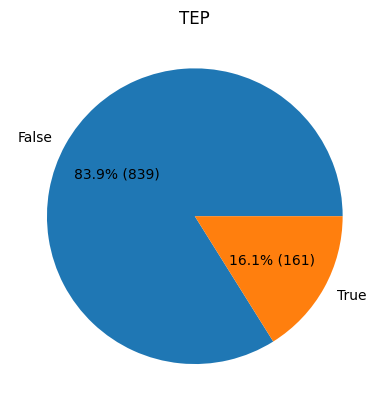

In [4]:
# Custom function to format the labels
def format_labels(pct, all_values):
    absolute = int(round(pct / 100.0 * sum(all_values)))
    formatted_absolute = format(absolute, ",").replace(",", ".")
    return f"{pct:.1f}% ({formatted_absolute})"


# Get value counts
value_counts = df["pe_positive"].value_counts()

# Plot the pie chart with percentage and absolute value
ax = value_counts.plot.pie(autopct=lambda pct: format_labels(pct, value_counts))

# Add title and labels
ax.set_title("TEP")
ax.set_ylabel("")

# Show the pie chart
plt.show()

# Classifying reports using keywords

### Searches the reports looking for the words in the list below
keywords = ['tromboembolismo', 'tep', 'falha de enchimento']

In [5]:
keywords = ["tromboembolismo", "tep", "falha de enchimento"]


def contains_keyword(report):
    # break report in paragraphs
    for paragraph in report.split("\n"):
        # search for each keyword in the paragraph
        for keyword in keywords:
            if keyword in paragraph:
                return True

    return False


# Create a new column 'simple_search' in the DataFrame
df["simple_search"] = df["report"].apply(contains_keyword)
df.head(5)

,report,pe_positive,simple_search
0,ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX\nTecn...,False,True
1,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False,True
2,ANGIOTOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndi...,False,True
3,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False,True
4,TOMOGRAFIA COMPUTADORIZADA DO TORAX\nIndicacao...,False,True


### Metrics

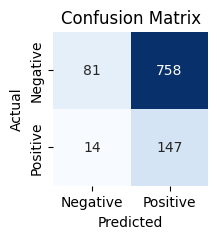


Performance Metrics:

Accuracy: 22.80%
Sensitivity (Recall): 91.30%
Specificity: 9.65%


In [6]:
def calculate_metrics(
    df_groundtruth: DataFrame,
    df_predicted: DataFrame,
    show_cm: bool = True,
    show_report: bool = True,
):
    # Calculate the confusion matrix
    cm = confusion_matrix(df_groundtruth, df_predicted)

    report = classification_report(
        df_groundtruth, df_predicted, target_names=["Negative", "Positive"]
    )

    if show_cm:
        # Create a heatmap of the confusion matrix
        plt.figure(figsize=(2, 2))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
        )

        # Set plot title and axis labels
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

        # Show the plot
        plt.show()

    if show_report:
        # Calculate and print performance metrics
        accuracy = accuracy_score(df_groundtruth, df_predicted)
        precision = precision_score(df_groundtruth, df_predicted)
        recall = recall_score(df_groundtruth, df_predicted)
        f1 = f1_score(df_groundtruth, df_predicted)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)

        print(black("\nPerformance Metrics:\n", "bold"))
        print(green(f"Accuracy: {accuracy * 100:.2f}%", "bold"))
        print(blue(f"Sensitivity (Recall): {recall * 100:.2f}%", "bold"))
        print(red(f"Specificity: {specificity * 100:.2f}%", "bold"))
        # print(f"Precision: {precision * 100:.2f}%")
        # print(f"F1 Score: {f1 * 100:.2f}%")


calculate_metrics(df["pe_positive"], df["simple_search"])

### Analysing some mistakes

In [8]:
def mark_keywords_in_report(text: str, keywords: list, legend: str):
    print(blue(f"keywords: {str(keywords)}\n", "bold"))

    for kw in keywords:
        text = text.replace(kw, red(kw, "bold"))

    print(f'{black(f"   >>> {legend} <<<", "bold")}\n\n{text}\n\n{"-"*90}\n')


# Choosing some sample mistakes
FP = df[(df.simple_search == True) & (df.pe_positive != df.simple_search)]
FN = df[(df.simple_search == False) & (df.pe_positive != df.simple_search)]

mark_keywords_in_report(FP.report.iloc[0], keywords, "FALSE POSITIVE")
mark_keywords_in_report(FN.report.iloc[1], keywords, "FALSE NEGATIVE")

keywords: ['tromboembolismo', 'tep', 'falha de enchimento']

   >>> FALSE POSITIVE <<<

ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX
Tecnica: exame realizado em tomografo multislice, com a administracao endovenosa de contraste iodado nao-ionico, com protocolo dirigido para a pesquisa de tep.

Analise:
Tronco pulmonar, arterias pulmonares direita e esquerda tem topografia, calibre e atenuacao para fluxo normais
Os ramos segmentares e subsegmentares das arterias pulmonares tem topografia, trajeto, calibre e atenuacao para fluxo preservados
Nao se observam estenoses ou dilatacoes das arterias pulmonares e seus ramos
Nao ha sinais de amputacao dos trajetos vasculares ou de outras caracteristicas de tromboembolismo pulmonar
Traqueia e bronquios principais de calibre e trajeto mantidos

Impressao:
Estudo negativo para tromboembolismo pulmonar

Obs.: achados adicionais descritos no estudo tomografico de torax realizado nesta mesma data.

-----------------------------------------------------------

# Text Cleaning 

### Case Lowering -> case lowering

  >>> Metrics for Simple Search (SS) <<<


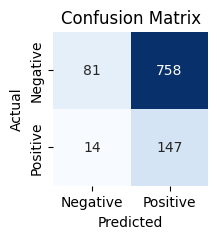


Performance Metrics:

Accuracy: 22.80%
Sensitivity (Recall): 91.30%
Specificity: 9.65%


  >>> Metrics for SS.lower() <<<


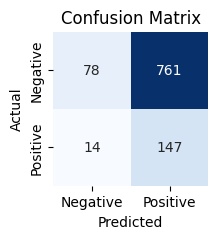


Performance Metrics:

Accuracy: 22.50%
Sensitivity (Recall): 91.30%
Specificity: 9.30%


In [9]:
def contains_keyword(report):
    report = report.lower()
    for paragraph in report.split("\n"):
        for keyword in keywords:
            if keyword.lower() in paragraph:
                return True

    return False


# Create a new column 'simple_search' in the DataFrame
df["lower_search"] = df["report"].apply(contains_keyword)

print(blue("  >>> Metrics for Simple Search (SS) <<<", "bold"))
calculate_metrics(df["pe_positive"], df["simple_search"])
print(blue("\n\n  >>> Metrics for SS.lower() <<<", "bold"))
calculate_metrics(df["pe_positive"], df["lower_search"])

In [10]:
# Choosing some sample mistakes
FP = df[(df.lower_search == True) & (df.pe_positive != df.lower_search)]

for i in range(5):
    mark_keywords_in_report(FP.report.iloc[i], keywords, "FALSE POSITIVE")

keywords: ['tromboembolismo', 'tep', 'falha de enchimento']

   >>> FALSE POSITIVE <<<

ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX
Tecnica: exame realizado em tomografo multislice, com a administracao endovenosa de contraste iodado nao-ionico, com protocolo dirigido para a pesquisa de tep.

Analise:
Tronco pulmonar, arterias pulmonares direita e esquerda tem topografia, calibre e atenuacao para fluxo normais
Os ramos segmentares e subsegmentares das arterias pulmonares tem topografia, trajeto, calibre e atenuacao para fluxo preservados
Nao se observam estenoses ou dilatacoes das arterias pulmonares e seus ramos
Nao ha sinais de amputacao dos trajetos vasculares ou de outras caracteristicas de tromboembolismo pulmonar
Traqueia e bronquios principais de calibre e trajeto mantidos

Impressao:
Estudo negativo para tromboembolismo pulmonar

Obs.: achados adicionais descritos no estudo tomografico de torax realizado nesta mesma data.

-----------------------------------------------------------

# Text Cleaning 

### Removing Stopwords

[',', '.', ':', 'a', 'as', 'cm', 'computadorizada', 'da', 'das', 'de', 'do', 'dos', 'e', 'em', 'o', 'os', 'tomografia']


### Removing Negative Keywords

['ausencia', 'nao ha']

In [11]:
# defining stopwords and negative words
stopwords = [",", ".", ":", "a", "as", "cm", "computadorizada", "da", "das", "de", "do", "dos", "e", "em", "o", "os", "para", "tomografia"]

negative_keywords = ["ausencia", "nao ha"]

  >>> Metrics for Simple Search (SS) <<<


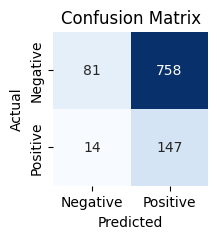


Performance Metrics:

Accuracy: 22.80%
Sensitivity (Recall): 91.30%
Specificity: 9.65%


  >>> Metrics for Stopword + lower() + Remove SW and Neg Keywords


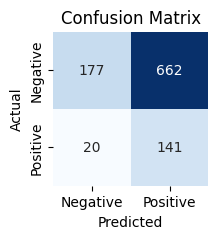


Performance Metrics:

Accuracy: 31.80%
Sensitivity (Recall): 87.58%
Specificity: 21.10%

------------------------------------------------------------------------------------------

keywords: ['tromboembolismo', 'tep', 'falha enchimento']

   >>> FALSE POSITIVE <<<

ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX
Tecnica: exame realizado em tomografo multislice, com a administracao endovenosa de contraste iodado nao-ionico, com protocolo dirigido para a pesquisa de tep.

Analise:
Tronco pulmonar, arterias pulmonares direita e esquerda tem topografia, calibre e atenuacao para fluxo normais
Os ramos segmentares e subsegmentares das arterias pulmonares tem topografia, trajeto, calibre e atenuacao para fluxo preservados
Nao se observam estenoses ou dilatacoes das arterias pulmonares e seus ramos
Nao ha sinais de amputacao dos trajetos vasculares ou de outras caracteristicas de tromboembolismo pulmonar
Traqueia e bronquios principais de calibre e trajeto mantidos

Impressao:
Estudo negativo para t

In [12]:
def remove_sw(report: str) -> str:
    fulltext = []
    for paragraph in report.split("\n"):
        paragraph = " ".join(
            [word for word in word_tokenize(paragraph) if word.lower() not in stopwords]
        )
        fulltext.append(paragraph)

    return "\n".join(fulltext)


def contains_keyword_remove_sw_neg_kw(report):
    report = report.lower()
    # split the report in paragraphs
    for paragraph in report.split("\n"):
        for neg_kw in negative_keywords:
            # verifies if this paragraph contains negative keywords. if it contains, do not analyse this line
            if neg_kw in paragraph:
                paragraph = ""
                break

        if paragraph != "":
            for keyword in keywords:
                if keyword in paragraph:
                    return True

    return False


# remove stopwords from keywords
keywords = [remove_sw(k) for k in keywords]

# Create a new column 'lower_sw_neg_kw_search' in the DataFrame
df["lower_sw_neg_kw_search"] = df["report"].apply(contains_keyword_remove_sw_neg_kw)

print(blue("  >>> Metrics for Simple Search (SS) <<<", "bold"))
calculate_metrics(df["pe_positive"], df["simple_search"], show_cm=True)
print(blue("\n\n  >>> Metrics for Stopword + lower() + Remove SW and Neg Keywords", "bold"))
calculate_metrics(df["pe_positive"], df["lower_sw_neg_kw_search"], show_cm=True)
print(f'\n{"-"*90}\n')

# Choosing some sample mistakes
FP = df[(df.lower_sw_neg_kw_search == True) & (df.pe_positive != df.lower_sw_neg_kw_search)]

for i in range(5):
    mark_keywords_in_report(FP.report.iloc[i], keywords, "FALSE POSITIVE")

  >>> Metrics for Simple Search (SS) <<<


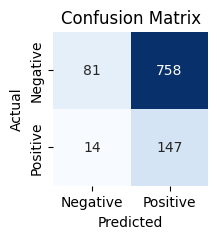


Performance Metrics:

Accuracy: 22.80%
Sensitivity (Recall): 91.30%
Specificity: 9.65%


  >>> Metrics for Stopword + lower() + Remove SW and Neg Keywords


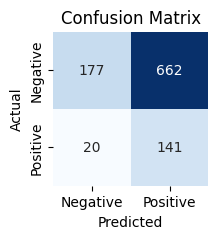


Performance Metrics:

Accuracy: 31.80%
Sensitivity (Recall): 87.58%
Specificity: 21.10%


  >>> Metrics for Stopword + lower() + Remove SW and Improved Neg Keywords


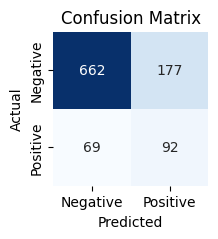


Performance Metrics:

Accuracy: 75.40%
Sensitivity (Recall): 57.14%
Specificity: 78.90%

------------------------------------------------------------------------------------------

keywords: ['tromboembolismo', 'tep', 'falha enchimento']

   >>> FALSE POSITIVE <<<

TOMOGRAFIA COMPUTADORIZADA DO TORAX

Tecnica:
Aquisicao volumetrica multiplanar em aparelho multidetectores, antes e apos administracao endovenosa meio de contraste iodado, nao ionico
Ultimo exame em 04/01/2022
Analise:
Ausencia de consolidacoes ou areas com atenuacao em vidro fosco suspeitas
Opacidades amorfas, heterogeneas, esparsas pelo parenquima pulmonar, notadamente no lobo inferior do pulmao direito
Traves fibroatelectasicas esparsas pelo parenquima pulmonar bilateralmente
Presenca de imagem nodular, espiculada, com densidade partes moles, apresentando discreto realce pelo meio de contraste, localizada no segmento basal lateral do pulmao direito, junto a grande cissura, medindo cerca de 1,5 x 0,6 cm
Nao ha derrame pl

In [13]:
# improve the negative words list
negative_keywords = ["ausencia", "nao ha"]
negative_keywords = ["ausencia", "nao ha", "controle", "cronic", "pesquisa", 'indicacao', 'tecnica', 'negativo']

# Create a new column 'lower_sw_neg_kw_search_2' in the DataFrame
df["lower_sw_neg_kw_search_2"] = df["report"].apply(contains_keyword_remove_sw_neg_kw)

print(blue("  >>> Metrics for Simple Search (SS) <<<", "bold"))
calculate_metrics(df["pe_positive"], df["simple_search"], show_cm=True)
print(blue("\n\n  >>> Metrics for Stopword + lower() + Remove SW and Neg Keywords", "bold"))
calculate_metrics(df["pe_positive"], df["lower_sw_neg_kw_search"], show_cm=True)
print(blue("\n\n  >>> Metrics for Stopword + lower() + Remove SW and Improved Neg Keywords", "bold",))
calculate_metrics(df["pe_positive"], df["lower_sw_neg_kw_search_2"], show_cm=True)
print(f'\n{"-"*90}\n')

# Choosing some sample mistakes
FP = df[
    (df.lower_sw_neg_kw_search_2 == True)
    & (df.pe_positive != df.lower_sw_neg_kw_search_2)
]

for i in range(5):
    mark_keywords_in_report(FP.report.iloc[i], keywords, "FALSE POSITIVE")

# How to improve this model:

- Better preprocessing
- Replacement Rules
- Use RegEx


To learn regex: https://regexone.com/

To test regex: https://regex101.com/

In [17]:
def mark_regex_in_report(text: str, pattern: Pattern, legend: str):
    print(blue(f"pattern: {str(pattern)}\n", "bold"))

    def replace_match(match):
        return red(match.group(0), "bold")

    text = re.sub(pattern, replace_match, text)

    print(f'{black(f"   >>> {legend} <<<", "bold")}\n\n{text}\n\n{"-"*90}\n')

report = '''
TOMOGRAFIA COMPUTADORIZADA DO TORAX
Indicacao clinica: tromboflebite, suspeita de tromboembolismo pulmonar tep
Tecnica: aquisicao volumetrica multiplanar em aparelho multidetectores
Meio de contraste: ev nao ionico, com protocolo de angiotomografia, para pesquisa de tep.

Analise:
Angiotomografia negativa para trombo embolismo pulmonar. tronco arterial pulmonar com calibre normal de 2,7 cm. septo interventricular de aspecto habitual. relacao vd ve normal
Aorta e demais estruturas vasculares mediastinais com situacao, calibres e contornos normais
Opacidades perifericas basais posteriores, atribuiveis ao decubito
Tenues opacidades de vidro fosco centrolobulares predominantes nos campos superiores compativeis com bronquiolite respiratoria relacionada ao tabagismo
Restante do parenquima pulmonar com coeficientes de atenuacao preservados
Espacos pleurais virtuais
Traqueia e bronquios principais com situacao, calibre e contornos normais.
Ausencia de linfonodomegalias
Achados da coluna vertebral descritos no estudo dirigido ressonancia magnetica de 25/07/2019
Restante do arcabouco osseo toracico sem alteracoes significativas

Opinião: Ausência de sinais de trombo-embolia
'''

regex_pattern = 'trombo[\s-]?emboli(a|smo)'

mark_regex_in_report(report, regex_pattern, regex_pattern)

pattern: trombo[\s-]?emboli(a|smo)

   >>> trombo[\s-]?emboli(a|smo) <<<


TOMOGRAFIA COMPUTADORIZADA DO TORAX
Indicacao clinica: tromboflebite, suspeita de tromboembolismo pulmonar tep
Tecnica: aquisicao volumetrica multiplanar em aparelho multidetectores
Meio de contraste: ev nao ionico, com protocolo de angiotomografia, para pesquisa de tep.

Analise:
Angiotomografia negativa para trombo embolismo pulmonar. tronco arterial pulmonar com calibre normal de 2,7 cm. septo interventricular de aspecto habitual. relacao vd ve normal
Aorta e demais estruturas vasculares mediastinais com situacao, calibres e contornos normais
Opacidades perifericas basais posteriores, atribuiveis ao decubito
Tenues opacidades de vidro fosco centrolobulares predominantes nos campos superiores compativeis com bronquiolite respiratoria relacionada ao tabagismo
Restante do parenquima pulmonar com coeficientes de atenuacao preservados
Espacos pleurais virtuais
Traqueia e bronquios principais com situacao, calibre 

# Transformer Architecture

The Transformer architecture is a neural network framework that employs self-attention mechanisms and parallelization for efficient natural language processing and sequence-to-sequence tasks.

It is important because it revolutionized natural language processing by enabling highly efficient and accurate models, leading to improved performance across a wide range of tasks, such as machine translation, summarization, and question-answering.

In [ ]:
!python -m spacy download pt_core_news_sm

In [ ]:
print("Loading Spacy Model\n")
nlp = spacy.load("pt_core_news_sm")

In [ ]:
def preprocess(report) -> str:
    report = report.lower()
    report = " ".join([token.text for token in nlp(report) if token.text not in stopwords])

    return report

print("Preprocessing the dataset\n")

df_spacy = df[["report", "pe_positive"]]

df_spacy["report"] = df_spacy["report"].progress_apply(preprocess)

In [ ]:
print("Splitting the dataset in train and test sets\n")
train_data, valid_data = train_test_split(
    df, test_size=0.2, random_state=4, stratify=df_spacy[["pe_positive"]]
)

print("Converting train and test datasets to tuples\n")
train_data = list(train_data.itertuples(index=False, name=None))
valid_data = list(valid_data.itertuples(index=False, name=None))
print("Done")

In [ ]:
def make_docs(data):
    docs = []

    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total=len(data)):
        # setting the category for each report
        doc.cats["pe_spacy"] = label

        # put them into a nice list
        docs.append(doc)

    return docs

try:
    os.mkdir("./data")
except:
    pass

print("Creating the binary train dataset\n")
train_docs = make_docs(train_data)
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./data/train.spacy")

print("Creating the binary validation dataset\n")
valid_docs = make_docs(valid_data)
doc_bin = DocBin(docs=valid_docs)
doc_bin.to_disk("./data/valid.spacy")

print("Training the model\n")
os.system("spacy train config.cfg --output ./output")

print("Done")

In [ ]:
#pip install -U 'spacy[cuda-autodetect]' spacy-transformers

In [ ]:
#!python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
# Train the model using Spacy
!spacy train config.cfg --output ./output --gpu-id 0

# Time to run the inferences using the trained model

If you prefer to use my pretrained model, you can download it here:

https://drive.google.com/file/d/1YQijlaqF41GbxglL6SRLG40CJYKtHQKq/view?usp=sharing

In [ ]:
# loads the NLP model trained for classifing normal vs abnormal chest xray reports
nlp = spacy.load('../output/model-best')

def predict(report: str) -> str:

    # preprocesses the report
    report = preprocess(report)

    # instantiates a nlp object containing the report
    doc = nlp(report)
    
    return doc.cats['pe_spacy'] > 0.5

df['pe_spacy'] = df['report'].progress_apply(predict)

In [19]:
df = pd.read_csv('tep_inferred.csv')
df

,report,pe_positive,simple_search,lower_search,lower_sw_neg_kw_search,lower_sw_neg_kw_search_2,pe_spacy
0,ANGIOTOMOGRAFIA COMPUTADORIZADA DE TORAX\r\nTe...,False,True,True,True,False,False
1,TOMOGRAFIA COMPUTADORIZADA DO TORAX\r\nIndicac...,False,True,True,False,False,False
2,ANGIOTOMOGRAFIA COMPUTADORIZADA DO TORAX\r\nIn...,False,True,True,True,False,False
3,TOMOGRAFIA COMPUTADORIZADA DO TORAX\r\nIndicac...,False,True,True,True,False,False
4,TOMOGRAFIA COMPUTADORIZADA DO TORAX\r\nIndicac...,False,True,True,True,False,False
...,...,...,...,...,...,...,...
995,ANGIOTOMOGRAFIA COMPUTADORIZADA COM PROTOCOLO ...,True,True,True,True,True,False
996,ANGIOTOMOGRAFIA COMPUTADORIZADA DO TORAX E TOM...,False,True,True,False,False,False
997,TOMOGRAFIA COMPUTADORIZADA DO TORAX E\r\nAngio...,False,True,True,True,False,False
998,ANGIOTOMOGRAFIA DE TORAX\r\nIndicacao clinica:...,False,True,True,True,False,False


### Comparing the metrics

  >>> Metrics for Simple Search (SS) <<<


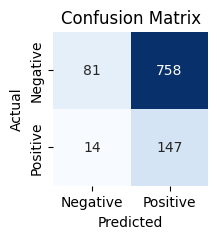


Performance Metrics:

Accuracy: 22.80%
Sensitivity (Recall): 91.30%
Specificity: 9.65%


  >>> Metrics for  SS + Remove SW and Improved Neg Keywords


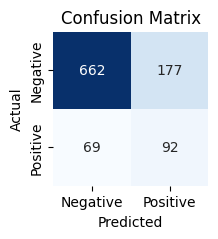


Performance Metrics:

Accuracy: 75.40%
Sensitivity (Recall): 57.14%
Specificity: 78.90%


  >>> Metrics for Transformer


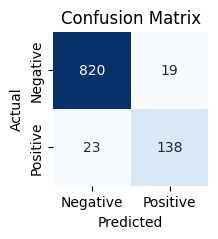


Performance Metrics:

Accuracy: 95.80%
Sensitivity (Recall): 85.71%
Specificity: 97.74%

------------------------------------------------------------------------------------------

keywords: ['tromboembolismo', 'tep', 'falha enchimento']

   >>> FALSE POSITIVE <<<

TOMOGRAFIA COMPUTADORIZADA DO TORAX

Tecnica:
Aquisicao volumetrica multiplanar em aparelho multidetectores, antes e apos administracao endovenosa meio de contraste iodado, nao ionico
Ultimo exame em 04/01/2022
Analise:
Ausencia de consolidacoes ou areas com atenuacao em vidro fosco suspeitas
Opacidades amorfas, heterogeneas, esparsas pelo parenquima pulmonar, notadamente no lobo inferior do pulmao direito
Traves fibroatelectasicas esparsas pelo parenquima pulmonar bilateralmente
Presenca de imagem nodular, espiculada, com densidade partes moles, apresentando discreto realce pelo meio de contraste, localizada no segmento basal lateral do pulmao direito, junto a grande cissura, medindo cerca de 1,5 x 0,6 cm
Nao ha derrame pl

In [24]:
print(blue("  >>> Metrics for Simple Search (SS) <<<", "bold"))
calculate_metrics(df["pe_positive"], df["simple_search"], show_cm=True)
print(blue("\n\n  >>> Metrics for  SS + Remove SW and Improved Neg Keywords", "bold",))
calculate_metrics(df["pe_positive"], df["lower_sw_neg_kw_search_2"], show_cm=True)
print(blue("\n\n  >>> Metrics for Transformer", "bold",))
calculate_metrics(df["pe_positive"], df["pe_spacy"], show_cm=True)
print(f'\n{"-"*90}\n')

# Choosing some sample mistakes
FP = df[(df.lower_sw_neg_kw_search_2 == True) & (df.pe_positive != df.lower_sw_neg_kw_search_2)]

for i in range(5):
    mark_keywords_in_report(FP.report.iloc[i], keywords, "FALSE POSITIVE")

In [ ]:
df.to_csv('tep_inferred.csv', index=False)